In [118]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data

In [ ]:
with open('../src/data/super_cleaned_mta_data_march.pickle', 'rb') as read_file:
    raw = pickle.load(read_file)
    
raw.head()

# 2. Add Weekday

In [41]:
raw['weekday'] = raw.start_datetime.dt.weekday < 5

In [44]:
raw.head(10)

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries,weekday
1,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.000000,False
2,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.000000,False
3,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.000000,False
4,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.000000,False
5,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.000000,False
6,A002,R051,02-00-00,59 ST,2019-02-23 23:00:00,2019-02-23 23:59:59,00:59:59,7.497917,False
7,A002,R051,02-00-00,59 ST,2019-02-24 03:00:00,2019-02-24 07:00:00,04:00:00,7.000000,False
8,A002,R051,02-00-00,59 ST,2019-02-24 07:00:00,2019-02-24 11:00:00,04:00:00,31.000000,False
9,A002,R051,02-00-00,59 ST,2019-02-24 11:00:00,2019-02-24 15:00:00,04:00:00,100.000000,False
10,A002,R051,02-00-00,59 ST,2019-02-24 15:00:00,2019-02-24 19:00:00,04:00:00,157.000000,False


In [159]:
len(raw.STATION.unique())

378

# 2. Explore Station Deviation

In [66]:
by_window = raw.groupby(['STATION', 'weekday', raw.start_datetime.dt.hour, raw.end_datetime.dt.hour]).agg({ 'entries': ['sum', 'count'] }).reset_index()

In [67]:
by_window.columns = ['_'.join(col).strip() for col in by_window.columns.values]
by_window = by_window.rename(columns={
    'STATION_': 'station',
    'start_datetime_': 'start_datetime',
    'end_datetime_': 'end_datetime',
    'weekday_': 'weekday'
})

In [68]:
by_window.head(10)


,station,weekday,start_datetime,end_datetime,entries_sum,entries_count
0,1 AV,False,0,3,342.0,40
1,1 AV,False,0,4,1763.0,50
2,1 AV,False,3,7,2.0,50
3,1 AV,False,4,8,405.0,50
4,1 AV,False,7,11,5.0,50
5,1 AV,False,8,12,2849.0,50
6,1 AV,False,11,15,10.0,50
7,1 AV,False,12,16,6204.0,50
8,1 AV,False,15,19,12.0,50
9,1 AV,False,16,20,6966.0,50


In [80]:
def get_time_of_day(row):
    if (row.start_datetime >= 2) and (row.end_datetime <= 9):
        return 'early_morning'
    elif (row.start_datetime >= 6) and (row.end_datetime <= 13):
            return 'late_morning'
    elif (row.start_datetime >= 10) and (row.end_datetime <= 17):
            return 'afternoon'
    elif (row.start_datetime >= 14) and (row.end_datetime <= 21):
            return 'evening'
    else:
        return 'other'

by_window['time_of_day'] = by_window.apply(get_time_of_day, axis=1)


In [81]:
by_window.head()


,station,weekday,start_datetime,end_datetime,entries_sum,entries_count,time_of_day
0,1 AV,False,0,3,342.0,40,other
1,1 AV,False,0,4,1763.0,50,other
2,1 AV,False,3,7,2.0,50,early_morning
3,1 AV,False,4,8,405.0,50,early_morning
4,1 AV,False,7,11,5.0,50,late_morning


In [86]:
by_window.groupby(['station', 'weekday', 'time_of_day']).agg({ 'entries_sum': 'sum'}).reset_index()


,station,weekday,time_of_day,entries_sum
0,1 AV,False,afternoon,6214.000000
1,1 AV,False,early_morning,407.000000
2,1 AV,False,evening,6978.000000
3,1 AV,False,late_morning,2854.000000
4,1 AV,False,other,6781.723090
...,...,...,...,...
3775,ZEREGA AV,True,afternoon,13759.000000
3776,ZEREGA AV,True,early_morning,27054.000000
3777,ZEREGA AV,True,evening,9780.000000
3778,ZEREGA AV,True,late_morning,14797.000000


In [101]:
diff = raw.start_datetime.max() - raw.start_datetime.min()
days_in_data_set = diff.total_seconds() / (3600 * 24)

by_window['days_observed'] = by_window.groupby(['station', 'weekday'])['start_datetime'].transform(lambda gp: gp.max() - gp.min())
by_window['entries_per_day'] = by_window['entries_sum'] / by_window['days_observed']



In [106]:
by_time_of_day = by_window.groupby(['station', 'weekday', 'time_of_day']).agg({ 'entries_sum': 'sum', 'days_observed': 'mean' }).reset_index()

In [112]:
by_time_of_day['avg_entries'] = by_time_of_day['entries_sum'] / by_time_of_day['days_observed']


In [161]:
by_time_of_day.head(30)


,station,weekday,time_of_day,entries_sum,days_observed,entries_per_day,avg_entries
0,1 AV,False,afternoon,6214.000000,23,270.173913,270.173913
1,1 AV,False,early_morning,407.000000,23,17.695652,17.695652
2,1 AV,False,evening,6978.000000,23,303.391304,303.391304
3,1 AV,False,late_morning,2854.000000,23,124.086957,124.086957
4,1 AV,False,other,6781.723090,23,294.857526,294.857526
5,1 AV,True,afternoon,100097.000000,23,4352.043478,4352.043478
6,1 AV,True,early_morning,26762.000000,23,1163.565217,1163.565217
7,1 AV,True,evening,157308.000000,23,6839.478261,6839.478261
8,1 AV,True,late_morning,124788.000000,23,5425.565217,5425.565217
9,1 AV,True,other,87743.154028,23,3814.919740,3814.919740


The max is ~5 people per second (which seems reasonable)

# Plot Single Station

In [136]:
by_time_of_day.station.sample(10)


2303           GRAND ST
3303        ROCKAWAY AV
3600     VAN SICLEN AVE
1725        BUSHWICK AV
1996          DEKALB AV
957                7 AV
2797    METS-WILLETS PT
2788    METROPOLITAN AV
2335    GRD CNTRL-42 ST
2573    JKSN HT-ROOSVLT
Name: station, dtype: object

In [171]:
station_name = 'TIMES SQ-42 ST'

weekday = by_time_of_day[(by_time_of_day.station == station_name) & by_time_of_day.weekday]
weekend = by_time_of_day[(by_time_of_day.station == station_name) & (~by_time_of_day.weekday)]



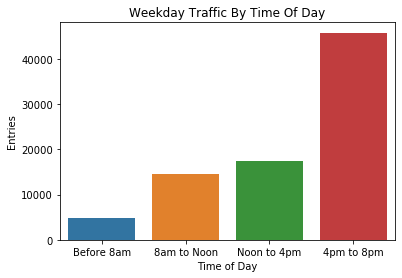

In [172]:
ax = sns.barplot(
    x='time_of_day',
    y='avg_entries',
    data=weekday,
    order=['early_morning', 'late_morning', 'afternoon', 'evening']
)
ax.set_title('Weekday Traffic By Time Of Day')
ax.set(
    xticklabels=['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'],
    xlabel='Time of Day',
    ylabel='Entries'
);

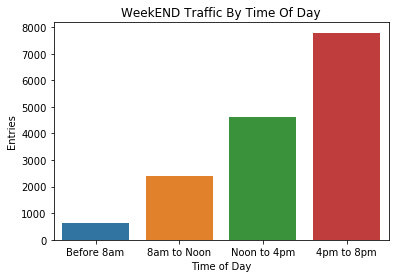

In [173]:
ax = sns.barplot(
    x='time_of_day',
    y='avg_entries',
    data=weekend,
    order=['early_morning', 'late_morning', 'afternoon', 'evening']
)
ax.set_title('WeekEND Traffic By Time Of Day')
ax.set(
    xticklabels=['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'],
    xlabel='Time of Day',
    ylabel='Entries'
);
